Вариант 1)
1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
​
2. Оцените ошибку модели из п.1 .
3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
​

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [4]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
data_arg = data['PJME_MW'].values
data_s = pd.DataFrame(data = data['PJME_MW'])

In [6]:
d_data=data.resample('D').mean()

In [7]:
data_s.head()

,PJME_MW
Date,
2002-01-01,30393.0
2002-01-01,29265.0
2002-01-01,28357.0
2002-01-01,27899.0
2002-01-01,28057.0


D:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


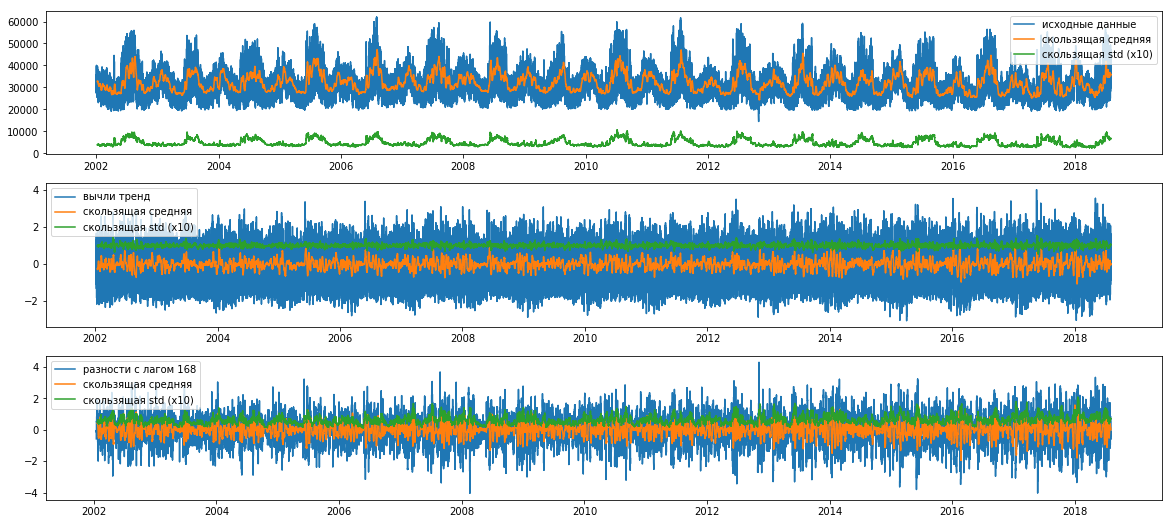

In [8]:
train = data_s.iloc[:-10, :]
test = data_s.iloc[-10:, :]


N2 = 24*7

data_s['z_data'] = (data_s['PJME_MW'] - data_s['PJME_MW'].rolling(window=N2).mean()) / data_s['PJME_MW'].rolling(window=N2).std()
data_s['zp_data'] = data_s['z_data'] - data_s['z_data'].shift(N2)

def plot_rolling(b_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(b_s.index, b_s['PJME_MW'], label='исходные данные')
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом" +' '+str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(data_s)

Экспоненциальное сглаживание

Text(0.5, 1.0, 'PJME_MW')

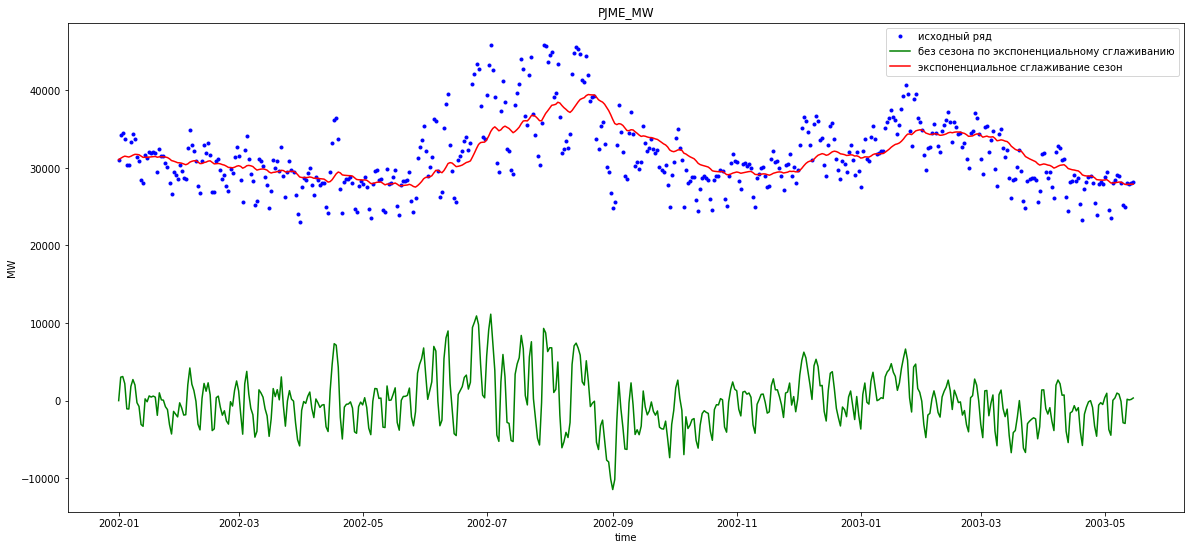

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

Тест Дики-Фулера

In [10]:
data_season_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) - data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_season_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138561908,
 4.2829746153967184e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

В результате получаем 0 и продолжаем расчет.

Добавляем авторегрессию с глубиной 3

In [12]:
df_exp_1 =  pd.DataFrame(data_exp_1, index = d_data.index)
df_exp_1.head()
df_exp_1['t'] = 0
df_exp_1.iloc[1:,1]=df_exp_1.iloc[:-1,0].values
df_exp_1['t1']=0
df_exp_1.iloc[2:,2]=df_exp_1.iloc[:-2,0].values
df_exp_1['t2']=0
df_exp_1.iloc[3:,3]=df_exp_1.iloc[:-3,0].values
df_exp_1.fillna(0)

df_exp_1.tail()

,0,t,t1,t2
Date,,,,
2018-07-30,35241.910443,35362.146957,35530.527499,35584.989473
2018-07-31,35206.769087,35241.910443,35362.146957,35530.527499
2018-08-01,35407.970216,35206.769087,35241.910443,35362.146957
2018-08-02,35617.223789,35407.970216,35206.769087,35241.910443
2018-08-03,35610.662599,35617.223789,35407.970216,35206.769087


Разделяем данные на test и train по значению 01-01-2018

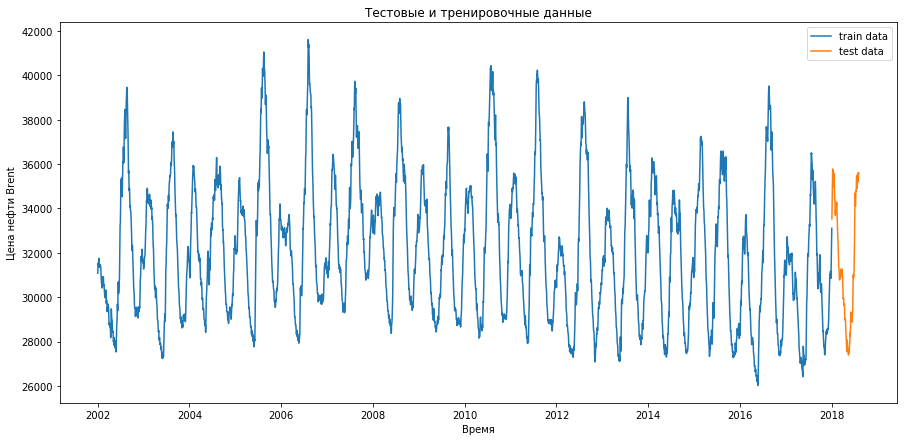

In [15]:
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df_exp_1, '01-01-2018')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df_exp_1.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df_exp_1.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index.get_level_values('Date'),train_b[df_exp_1.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df_exp_1.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Прогноз ряда при глубине h=1

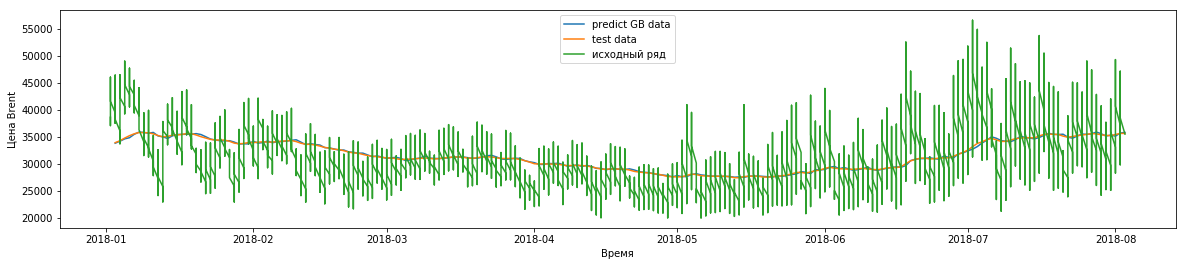

ошибка градиентного бустинга :   0.40465166744428915 %


In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(data_s.loc['2018-01-02':].index, data_s.loc['2018-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Прогноз ряда при глубине h=10

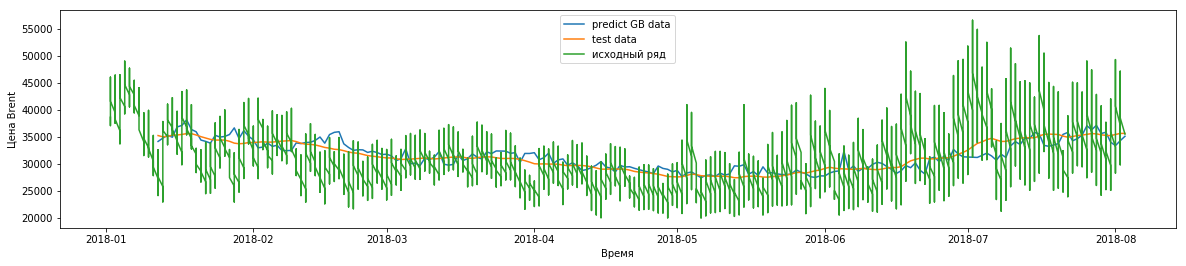

ошибка градиентного бустинга :   2.975091210822581 %


In [17]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df_exp_1.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df_exp_1.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(data_s.loc['2018-01-02':].index, data_s.loc['2018-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

#### При увеличении горизонта прогноза ошибка модели увеличивается. Это связано с тем, что в расчете модели может попасть шум, выбросы и прочие аномалии, которые не были зафиксированы на более коротком периоде

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):
​
а) Изменение температуры за окном :).
​
б) Количество денег, которые тратят покупатели в интернет магазине.
​
в) Вес растущего котенка.
​
г) Прирост объема деревьев в лесу от времени

а) Изменение температуры за окном :).
Нестанционарный т.к. присутствует сезонность.

б) Количество денег, которые тратят покупатели в интернет магазине.
Нестационарный т.к. имеет место быть сезонность и тренд.

в) Вес растущего котенка.
Нестационарный т.к. присутствует тренд.

г) Прирост объема деревьев в лесу от времени
Нестационарный т.к. скорее всего будет наблюдаться тренд.